## ReadMe
Codes from AdML and DL classes, changed some details, but still need improvement.


Finally, we got following results

| Metric| Result|
| --- | --- |
| Test RMSE:|59.81580|
| Test R^2 Score: |0.86933|
| Test MAPE:|11.07628%|



## **Environment Setup**

1. Mount our google drive directory
2. Set the current directory in our python runtime



In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

import os
os.chdir('/Users/yebi/Library/CloudStorage/OneDrive-VirginiaTech/Research/Codes/research/BCS/BodyWeight')
# os.chdir('/content/drive/MyDrive/Ye/Projects/DairyComputerVision/BodyWeight') 

# os.chdir('/content/drive/MyDrive/Students/Ye/Projects/DairyBCS/BodyWeight')
# os.chdir('/content/drive/MyDrive/School/CS5824/FINALPROJECT/')
!pwd

/Users/yebi/Library/CloudStorage/OneDrive-VirginiaTech/Research/Codes/research/BCS/BodyWeight


## **Necessary Imports**

In [2]:
##opencv
# from google.colab.patches import cv2_imshow
import cv2

import numpy as np
from glob import glob #read img path.
import pandas as pd
from pathlib import Path
import os.path

##tensorflow and keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import r2_score

## **Parse Drive Directory for Cow Data**

REQUIREMENTS:
1. The data_dir variable contains the directory which contains each of the day folders.
2. Each day folder contains depth, CSV, and RGB subfolders

data_dir
> D1
>> depth\
>> CSV\
>> RGB

Where each of the depth, CSV, and RGB folders store folders which have name (COWID)AM or (COWID)PM
and store their respective data.

The day folders should be formatted like so:

D1
>depth
>>2343AM
>>>__123412.png

>>2343PM
>>>__123412.png

In [3]:
# Store paths to all cow images
import string
import re
day_regex = 'D\d+$'
# data_dir = '/2020DairyLMC/'
root_dir = '/Volumes/MyPassport1/'
# root_dir = os.getcwd() + data_dir   # CHANGE THIS TO MATCH YOUR FOLDER STRUCTURE
                                    # SHOULD BE WERE ALL THE DX FOLDERS ARE LOCATED
# day_dirs = list(filter(lambda day: re.search(day_regex, day), os.listdir(root_dir)))

day_dirs = []
for i in range(1,29):
    day_dirs.append("D" + str(i))

print('Inside of: ', root_dir)
print('Got information for days: ', ', '.join(day_dirs))

depth_dir = '/depth/'
csv_dir = '/CSV/'
rgb_dir = '/RGB/'

cow_depth_paths = np.array([], dtype=np.unicode_)   # Path to all cow depth data folders
cow_csv_paths = np.array([], dtype=np.unicode_)     # Path to all cow depth data folders
cow_rgb_paths = np.array([], dtype=np.unicode_)     # Path to all cow depth data folders

for day in day_dirs:
  print('Beginning parse of ', day)
  temp_depth_dir = root_dir + day + depth_dir
  temp_csv_dir = root_dir + day + csv_dir
  temp_rgb_dir = root_dir + day + rgb_dir

  try:
    print('Attempting to parse depth in ', day)
    for cow_dir in os.listdir(temp_depth_dir): # PARSE depth SUBDIRECTORY (/DX/depth/)
      cowid = temp_depth_dir + cow_dir
      for image in os.listdir(cowid):
        if image[0] =='.':
          continue

        path_from_cwd = root_dir + day + depth_dir + cow_dir + '/'
        # path_from_cwd = '.' + data_dir + day + depth_dir + cow_dir + '/'
        cow_depth_paths = np.append(cow_depth_paths, path_from_cwd + image)
  except FileNotFoundError:
    print(day, '/depth was not found. Skipping to the next.')

  # try:
  #   print('Attempting to parse RGB in ', day)
  #   for cow_dir in os.listdir(temp_rgb_dir): # PARSE RGB SUBDIRECTORY (/DX/CSV/)
  #     cowid = temp_rgb_dir + cow_dir
  #     for image in os.listdir(cowid):
  #       path_from_cwd = '.' + data_dir + day + rgb_dir + cow_dir + '/'
  #       cow_rgb_paths = np.append(cow_rgb_paths, path_from_cwd + image)
  # except FileNotFoundError:
  #   print(day, '/RGB was not found. Skipping to the next.')

  try:
    print('Attempting to parse CSV in ', day)
    for cow_dir in os.listdir(temp_csv_dir): # PARSE CSV SUBDIRECTORY (/DX/RGB/)
      cowid = temp_csv_dir + cow_dir
      for image in os.listdir(cowid):
        if image[0] == '.':
          continue
        path_from_cwd = root_dir + day + csv_dir + cow_dir + '/'
        # path_from_cwd = '.' + data_dir + day + csv_dir + cow_dir + '/'
        cow_csv_paths = np.append(cow_csv_paths, path_from_cwd + image)
  except FileNotFoundError:
    print(day, '/CSV was not found. Skipping to the next.')
    
  print('Finished parsing: ', day)

Inside of:  /Volumes/MyPassport1/
Got information for days:  D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, D16, D17, D18, D19, D20, D21, D22, D23, D24, D25, D26, D27, D28
Beginning parse of  D1
Attempting to parse depth in  D1
Attempting to parse CSV in  D1
Finished parsing:  D1
Beginning parse of  D2
Attempting to parse depth in  D2
Attempting to parse CSV in  D2
Finished parsing:  D2
Beginning parse of  D3
Attempting to parse depth in  D3
Attempting to parse CSV in  D3
Finished parsing:  D3
Beginning parse of  D4
Attempting to parse depth in  D4
Attempting to parse CSV in  D4
Finished parsing:  D4
Beginning parse of  D5
Attempting to parse depth in  D5
Attempting to parse CSV in  D5
Finished parsing:  D5
Beginning parse of  D6
Attempting to parse depth in  D6
Attempting to parse CSV in  D6
Finished parsing:  D6
Beginning parse of  D7
Attempting to parse depth in  D7
Attempting to parse CSV in  D7
Finished parsing:  D7
Beginning parse of  D8
Attempting to parse dep

### **Cow Path Information**

Now the paths to all found files will be stored in cow_depth_paths, cow_rgb_paths, and cow_csv_paths respectively.

All indices in each of the lists are of the form:

./COW_DATA/D5/depth/5687PM/_Depth_61321.png

(NOTE THAT THIS PATH IS UNIQUE TO MY OWN ENVIRONMENT. IT MAY LOOK DIFFERENT FOR YOU.)

In [4]:
print(cow_depth_paths.shape)

(40368,)


## **Cow Weight Information Fetching**

Now grab the read weights from the csv file.\
The CSV file should be able to be found on the top level of the data_dir directory, on the same
level as the D1, D2, ...., DN folders.

First, read the CSV file into a dataframe.\
Then we will match up the provided weights from the CSV with the depths they correspond to on a daily basis.

In [5]:
bw_csv_path = '/Users/yebi/Library/CloudStorage/OneDrive-VirginiaTech/Research/Codes/research/BCS/BodyWeight/BWData/' + 'BodyWeight_cleaned.csv'
bw_df = pd.read_csv(bw_csv_path) # Read weight csv into a pandas dataframe

# Get the largest 'day' number out of all found days
largest_day = 0
for day in day_dirs:
  if (int(day[1:]) > largest_day):
    largest_day = int(day[1:])
daily_labelled_depth_images = [[] for _ in range(largest_day)]

for i in range(len(cow_depth_paths)):
  split_depth_path = cow_depth_paths[i].split('/')
  # day_inf = split_depth_path[-4]
  day_str = int(split_depth_path[-4][1:])      # Used to access the weight dataframe
  day_idx = int(day_str) - 1              # Take a day string (ie D5), isolate '5' and subtract 1
                                          # convert to array index
  id = split_depth_path[-2]               # The cowid, of the form XXXXAM or XXXXPM

  try:
    weight = bw_df[bw_df.DAY == day_str][id].values[0] # grab the weight for given cow
  except KeyError:
    continue
  daily_labelled_depth_images[day_idx].append([cow_depth_paths[i], day_str, weight])

daily_labelled_depth_images = np.array(daily_labelled_depth_images, dtype=object)

## **Format Of daily_labelled_depth_images**

1st Dimension\
The array daily_labelled_depth_images will contain an array for each day between the largest day value (D10 for example) and the smallest day value (D1). Any folders which happened to not be found or exist in this range will appear as empty lists.

2nd Dimension\
The second dimension of daily_labelled_depth_images contains lists of length two which contain\
[PATH_TO_DEPTH_IMAGE, ASSOCIATED WEIGHT]

We also create a version of this information where each day's information is combined into a single list, removing the first dimension of daily_labelled_depth_images.

This is then converted into a DataFrame with the first column labelled 'FilePath' and the second column labelled 'Weights'

In [6]:
labelled_depth_images = []
for day in daily_labelled_depth_images:
  labelled_depth_images += day
labelled_depth_images = np.array(labelled_depth_images, dtype=object)
labelled_depth_images

array([['/Volumes/MyPassport1/D1/depth/4973AM/_Depth_1237.png', 1,
        772.0006059689],
       ['/Volumes/MyPassport1/D1/depth/4973AM/_Depth_1238.png', 1,
        772.0006059689],
       ['/Volumes/MyPassport1/D1/depth/4973AM/_Depth_1239.png', 1,
        772.0006059689],
       ...,
       ['/Volumes/MyPassport1/D28/depth/5532PM/_Depth_105.png', 28,
        464.93217925],
       ['/Volumes/MyPassport1/D28/depth/5532PM/_Depth_106.png', 28,
        464.93217925],
       ['/Volumes/MyPassport1/D28/depth/5532PM/_Depth_107.png', 28,
        464.93217925]], dtype=object)

In [7]:
col_vals = ['FilePath', 'Days', 'Weights']
labelled_depth_images = pd.DataFrame(data=labelled_depth_images, columns=col_vals)
labelled_depth_images['FilePath'] = labelled_depth_images['FilePath'].astype(str)
labelled_depth_images['Days'] = labelled_depth_images['Days'].astype(int)
labelled_depth_images['Weights'] = labelled_depth_images['Weights'].astype(float)
labelled_depth_images = labelled_depth_images[-np.isnan(labelled_depth_images['Weights'])]
print("Number of labelled depth images is: %d" %labelled_depth_images.shape[0])
labelled_depth_images

Number of labelled depth images is: 38258


,FilePath,Days,Weights
0,/Volumes/MyPassport1/D1/depth/4973AM/_Depth_12...,1,772.000606
1,/Volumes/MyPassport1/D1/depth/4973AM/_Depth_12...,1,772.000606
2,/Volumes/MyPassport1/D1/depth/4973AM/_Depth_12...,1,772.000606
3,/Volumes/MyPassport1/D1/depth/4973AM/_Depth_12...,1,772.000606
4,/Volumes/MyPassport1/D1/depth/4973AM/_Depth_12...,1,772.000606
...,...,...,...
39119,/Volumes/MyPassport1/D28/depth/5532PM/_Depth_1...,28,464.932179
39120,/Volumes/MyPassport1/D28/depth/5532PM/_Depth_1...,28,464.932179
39121,/Volumes/MyPassport1/D28/depth/5532PM/_Depth_1...,28,464.932179
39122,/Volumes/MyPassport1/D28/depth/5532PM/_Depth_1...,28,464.932179


## **Create Train / Validation / Test Split, Load Images**

Prepare the images for use in the CNN now. Create the train_test_split, then create
ImageDataGenerator objects to scale the pixel values for each depth image, and subsequently create
a validation set out of the training set.

In [8]:
train_df = labelled_depth_images.loc[labelled_depth_images['Days'] <= 20]
test_df = labelled_depth_images.loc[labelled_depth_images['Days'] > 20]

In [9]:
print("Training set size is %d" %train_df.shape[0])
print("Test set size is %d" %test_df.shape[0])

Training set size is 26695
Test set size is 11563


In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale =1./255,
    validation_split = 0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='FilePath',
    y_col='Weights',
    target_size=(120,120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=10,
    shuffle=True,
    seed=42,
    subset='training',
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='FilePath',
    y_col='Weights',
    target_size=(120,120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=10,
    shuffle=True,
    seed=42,
    subset='validation',
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='FilePath',
    y_col='Weights',
    target_size=(120,120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=10,
    shuffle=False,
)

Found 21356 validated image filenames.
Found 5339 validated image filenames.
Found 11563 validated image filenames.


## **CNN Design**

The code below outlines the architecture of the CNN we use.

The first Conv2D layer uses a large inital kernal size because the only feature in the input image is the cow itself, which covers a significant amount of area. Being able to absorb this information spread out across fewer filters will allow us to better capture the relationship between the area it is occupying and its resulting weight prediction - in theory.

The remaining layers function have no special modifications.

In [12]:
inputs = tf.keras.Input(shape=(120,120,3))
x = tf.keras.layers.Conv2D(filters=8, kernel_size=(30,30), activation='relu')(inputs)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



## **CNN Training**

For training we use the Adam Optimizer and MSE loss.

We also perform early stopping checks in the event validation error rises. If the early stopping criteria is not hit, then we will perform 100 epochs of training.

In [13]:
cnn = tf.keras.Model(inputs = inputs, outputs = outputs)
cnn.summary()
cnn.compile(
    optimizer='adam',
    loss='mse'
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 8)         21608     
                                                                 
 average_pooling2d (AverageP  (None, 45, 45, 8)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 43, 43, 32)        2336      
                                                                 
 average_pooling2d_1 (Averag  (None, 21, 21, 32)       0         
 ePooling2D)                                                     
                                                                 
 global_average_pooling2d (G  (None, 32)               0     

In [15]:
history = cnn.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
2136/2136 [==============================] - 948s 444ms/step - loss: 15645.9023 - val_loss: 7872.0688
Epoch 2/100
2136/2136 [==============================] - 1012s 474ms/step - loss: 5684.9736 - val_loss: 5354.8462
Epoch 3/100
2136/2136 [==============================] - 1008s 472ms/step - loss: 3222.3303 - val_loss: 2049.8167
Epoch 4/100
2136/2136 [==============================] - 1000s 468ms/step - loss: 1848.4495 - val_loss: 1605.5104
Epoch 5/100
2136/2136 [==============================] - 997s 467ms/step - loss: 1523.0299 - val_loss: 3358.4583
Epoch 6/100
2136/2136 [==============================] - 1013s 474ms/step - loss: 1357.1393 - val_loss: 1551.9669
Epoch 7/100
2136/2136 [==============================] - 1039s 486ms/step - loss: 1239.4065 - val_loss: 1443.3578
Epoch 8/100
2136/2136 [==============================] - 1034s 484ms/step - loss: 1129.9186 - val_loss: 1668.1013
Epoch 9/100
2136/2136 [==============================] - 1031s 483ms/step - loss: 1001.38

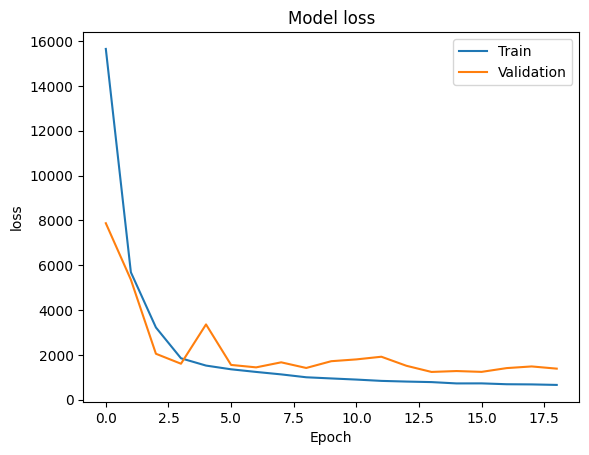

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [17]:
cnn.save("./python/cnn/cnn_weights_forcast_20_8.h5")

## **Making Predictions on Test Set**

Here we run the test images through the trained CNN, and get predictions on the weights.

We also want to perfrom some amount of backend CV. To do so, select a single cow from each day and grab its associated measured weight, and perform a prediction.

These selected values will also be scored in the next block, at the same time as the entire testing set.

In [14]:
cnn.load_weights("./python/cnn/cnn_weights_forcast_20_8.h5")

In [15]:
import random
predicted_weights = np.squeeze(cnn.predict(test_images))
true_weights = test_images.labels

2023-05-03 15:35:17.788242: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1157/1157 [==============================] - 119s 103ms/step


## **Model Evaluation / Metric Determination**

To demonstrate the total quality of the ending model we find the RMSE and R^2 scores.

The RMSE demonstrates exactly how far from some regression line our data points are. Smaller is better.

The R^2 score demonstrates how much variation in our prediction is explained by the input images. Typically, larger means better. In our case this is the degree to which our predictions' variance can be explained by the contents of the image itself - or essentially how much our model is actually using those pixels to generate a conclusion.

In [16]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [19]:
from sklearn.metrics import mean_squared_error 
print('METRICS ON ENTIRE DATASET:')
print('--------------------------')
# rmse = np.sqrt(cnn.evaluate(test_images, verbose=0))
rmse = mean_squared_error(true_weights, predicted_weights)**0.5
print("Test RMSE:\t{:.5f}".format(rmse))
r2 = r2_score(true_weights,predicted_weights)
print("Test R^2 Score:\t{:.5f}".format(r2))
MAPE = mape(true_weights, predicted_weights)
print("Test MAPE:\t{:.5f}%".format(MAPE))
print('--------------------------')

METRICS ON ENTIRE DATASET:
--------------------------
Test RMSE:	59.81580
Test R^2 Score:	0.86933
Test MAPE:	11.07628%
--------------------------
